In [2]:
pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import torchtext
from tqdm import tqdm
import numpy as np
import pandas as pd
import gzip
import json
import spacy
import gc
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import random

def load_data(file_name, head=200000, sep=True):
    count = 0
    data, neg_data, pos_data = [], [], []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            if sep == True:
                bid, title, tws = d['book_id'], d['title'], d['title_without_series']
                data.append((bid, title, tws))
            else:
              if d['has_spoiler']:
                pos_data.append(d)
              else:
                neg_data.append(d)

            if (head is not None) and (count > head):
                break
    if sep:
      return data
    return pos_data, neg_data

# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torchtext.data import Field, TabularDataset, BucketIterator

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [7]:
gr_books = load_data("/content/drive/MyDrive/goodreads_books.json.gz", head=1e8)
t_data, f_data = load_data('/content/drive/MyDrive/goodreads_reviews_spoiler.json.gz', sep=False, head=1e8)

book_ids = {}
for bid, title, tws in gr_books:
    book_ids[bid] = title

pos_dataset, neg_dataset = [], []
for d in t_data:
    title = book_ids[d['book_id']]
    s = ''
    for label, sentence in d['review_sentences']:
        s += sentence + ' '
    pos_dataset.append(("Book Title: " + title + "; Review: " + s, d['has_spoiler']))
for d in f_data:
    title = book_ids[d['book_id']]
    s = ''
    for label, sentence in d['review_sentences']:
        s += sentence + ' '
    neg_dataset.append(("Book Title: " + title + "; Review: " + s, d['has_spoiler']))
print(neg_dataset[0])

('Book Title: Invisible Man; Review: Recommended by Don Katz. Avail for free in December: http://www.audible.com/mt/ellison2?so... ', False)


In [8]:
random.shuffle(neg_dataset)
neg_dataset = neg_dataset[:120000]
new_dataset = neg_dataset + pos_dataset
print(len(new_dataset))

209627


In [9]:
train_test_ratio=0.9
train_valid_ratio=0.889
df = pd.DataFrame(new_dataset, columns=['text', 'label'])
df.loc[df['label'] == False, 'label'] = 0
df.loc[df['label'] == True, 'label'] = 1
df_real = df[df['label'] == 0]
df_fake = df[df['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
destination_folder = '.'
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [3]:
df_train = pd.read_csv('train.csv')
df_valid = pd.read_csv('valid.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,text,label
0,Book Title: No Country for Old Men; Review: St...,0
1,Book Title: Lord of Emperors (The Sarantine Mo...,0
2,Book Title: The Redemption of Callie & Kayden ...,0
3,"Book Title: Equal Rites (Discworld, #3; Witche...",0
4,"Book Title: Wonder; Review: Wow, definitely an...",0


In [4]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='basic_english', lower=True, include_lengths=True, batch_first=True)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='.', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [5]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.detach().cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len.detach().cpu() - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [6]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):
    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [16]:
import time

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 4,
          file_path = '.',
          best_valid_loss = float("Inf")):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        t1 = time.time()
        for i, (((titletext, titletext_len), labels), _) in enumerate(train_loader):
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # update running values
            running_loss += loss.item()
            global_step += 1
            if i % 1000 == 0:
                print(i)
                t2 = time.time()
                print(t2 - t1)
                t1 = t2

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                  # validation loop
                  for ((titletext, titletext_len), labels), _  in valid_loader:
                      labels = labels.to(device)
                      titletext = titletext.to(device)
                      titletext_len = titletext_len.to(device)
                      output = model(titletext, titletext_len)
                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()
                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                # resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()
                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))

                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
train(model=model, optimizer=optimizer, num_epochs=10)

0
1.463585615158081
1000
14.721675395965576
2000
21.842344999313354
Epoch [1/10], Step [2621/52420], Train Loss: 0.4428, Valid Loss: 0.6027
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
3000
35.076417684555054
4000
38.30878663063049
5000
59.576083183288574
Epoch [1/10], Step [5242/52420], Train Loss: 0.5781, Valid Loss: 0.8640
0
0.16153812408447266
1000
18.217118978500366
2000
19.91714859008789
Epoch [2/10], Step [7863/52420], Train Loss: 0.3784, Valid Loss: 0.5266
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
3000
35.13829708099365
4000
38.92085909843445
5000
59.44866156578064
Epoch [2/10], Step [10484/52420], Train Loss: 0.5229, Valid Loss: 0.6427
0
0.11861419677734375
1000
14.917878866195679
2000
20.011336088180542
Epoch [3/10], Step [13105/52420], Train Loss: 0.3328, Valid Loss: 0.5037
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
3000
39.24374532699585
4000
38.183069944381714
5000
61.04257941246033
Epoch [3/10], Step [15726/52420], T

Model loaded from <== ./model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7103    0.7256    0.7179      8963
           0     0.7917    0.7789    0.7853     12000

    accuracy                         0.7561     20963
   macro avg     0.7510    0.7523    0.7516     20963
weighted avg     0.7569    0.7561    0.7565     20963



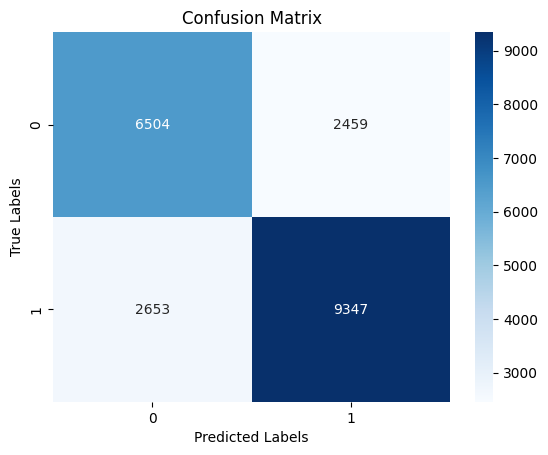

In [18]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for ((titletext, titletext_len), labels), _ in test_loader:
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels([0, 1])
    ax.yaxis.set_ticklabels([0, 1])


best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('.' + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)